# Posterior calculations for d

Here we use the data from the cluster to fit a prior GMM distribution function to the perpendicular distance d. Then we will define a likelihood on the data and derive a posterior distance function using the high latitude sample.

# Prior

Many of my algos have been written for torch but its fairly simple to swap to numpy.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import torch
os.chdir('../')
from star_sample import Isochrones,StarSample
from Distributions.xdeconv import XDGMM
os.chdir('Data')
prior_df=pd.read_csv('prior_data')
pkl_file = open('isochrones_high_lat.pkl', 'rb')

Isochrone_hl = pickle.load(pkl_file)

pkl_file = open('high_lat_values.pkl', 'rb')

High_Latitude_sample = pickle.load(pkl_file)
os.chdir('../')

# Prior

We are going to fit an XDGMM to the perpendicular distance to get a prior on $d$.

In [2]:
d_obs=prior_df['perp'].copy().to_numpy()
d_obs_err=np.sqrt(prior_df['perp_err'].copy().to_numpy())

We use 5 components. There is an official test but I just did this by eye.

In [3]:
gmm=XDGMM(5).fit(d_obs.reshape(len(d_obs),1),Xerr=(d_obs_err**2).reshape(len(d_obs_err),1,1),R=np.array([1.0]).reshape(1,1,1))


### Comparison of the GMM with true data

In [82]:
sam.shape

(10000, 1)

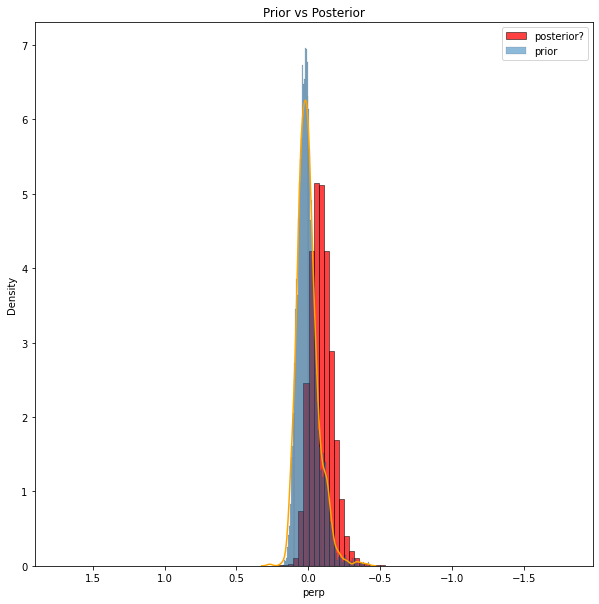

In [95]:
sam=gmm.sample(10000)
f, ax = plt.subplots(1, 1, figsize=(10,10))
plt.title('Prior vs Posterior')
sn.histplot(samp,ax=ax,bins=100,stat='density',color='r',label='posterior?',kde=False)
#sn.histplot(prior_df['perp'],ax=ax,kde=False,bins=100,stat='density',color='r')
sn.kdeplot(prior_df['perp'],ax=ax,color='orange')
sn.histplot(sam,ax=ax,bins=100,stat='density',color='b',label='prior')

#
#sn.kdeplot(sam,ax=ax,color='black')
plt.legend()
ax.invert_xaxis()
plt.show()

### Retrieve the Prior on $d$.
This is only the prior on the observed, we need to derive it in general.

In [5]:
mixing_coeff=gmm.alpha
means=gmm.mu
variance=gmm.V

# Posterior

We will begin only with Gaia magnitudes for now.

Assume: distance is known perfectly from the Bailer Jones. This later will have to be included in the model and we have our own prior on parallax.

In [6]:
High_Latitude_sample.data['G']=High_Latitude_sample.data['phot_g_mean_mag']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5

In [7]:
len(High_Latitude_sample.data)

88772

Make some cuts on logg and the distance.

In [8]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']>4.0].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']<5.0].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['r_med_geo']<1000.0].reset_index(drop=True)

### Create the dataframe by stacking the isochrones, producing isochrones which are of loggage 9.0 and FeH which has been produced from the calibration provided by Gaia and the GSP_Phot values. We concatenate them together into a datacube. This datacube is what is going to be fed into the model.

In [9]:
stacked_isochrones=Isochrone_hl.stack_isochrones()
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [10]:
age_list=[9.0]
feh_list=High_Latitude_sample.data['mh_gspphot'].values#feh_list=[0.17 for i in range(len(x_values))]#Cluster_sample.data['mh_gspphot']
stacked_isochrones=Isochrone_hl.stack_isochrones_subsample(feh_list,age_list)

In [11]:
x_columns=High_Latitude_sample.data.columns
isoc_columns=Isochrone_hl.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [12]:
isochrone=torch.cat([x_values,stacked_isochrones],dim=-1)

In [13]:
isochrone.shape

torch.Size([33924, 96, 55])

In [14]:
isochrone=isochrone.numpy()

# NumPyro

In [15]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

rng_key = random.PRNGKey(0)
assert numpyro.__version__.startswith("0.10.1")

In [16]:
isochrone=jnp.array(isochrone)

Move the isochrone

In [17]:
import math


In [18]:
m=math.atan(2.02)
dx=math.cos(m)
dy=math.sin(m)

x_val=isochrone[:,:,column_index('BPRP')]+dx
y_val=isochrone[:,:,column_index('Gaia_G_EDR3')]+dy


In [19]:
xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]

In [20]:
x_input=jnp.stack([xc_meas,xg_meas],axis=1)
x_err=jnp.stack([xc_std,xg_std],axis=1)

In [21]:
mixing_dist = mixing_dist = dist.Categorical(probs = jnp.array(mixing_coeff))
component_dists = [
    dist.Normal(loc=means[i], scale=jnp.sqrt(variance[i])) for i in range(len(means))]
# is it variance or variance squared
mixture = dist.MixtureGeneral(mixing_dist, component_dists)


In [22]:
#that will need to be reshaped
samples=mixture.sample(key=rng_key,sample_shape=(1000,))

# I'm having trouble figuring out how to evaluate the likelihood of all of the different points. However, if every point splits into two points and then I stack them with repeated values in x_err and x_g etc that could work. I would like to be able to do this but I'm running out of memory. Something could be done.

In [23]:
#var=jnp.array([jnp.diag(x_err[:,i]) for i in range (len(x_err))])


In [24]:
import math
d=numpyro.sample("d",mixture,rng_key=rng_key).reshape(1)

dx=math.cos(m)
dy=math.sin(m)

transformed_x=isochrone[:,:,column_index('BPRP')]+d*dx
transformed_y=isochrone[:,:,column_index('Gaia_G_EDR3')]+d*dy

transformed=jnp.stack([transformed_x,transformed_y],axis=1)

with numpyro.plate('data',len(x_err)):
    for i in range(transformed_x.shape[1]):
        numpyro.sample("obs_x",dist.Normal(transformed_x[:,i],xc_std**2),rng_key=rng_key,obs=xc_meas)
        numpyro.sample("obs_y",dist.Normal(transformed_y[:,i],xg_std**2),rng_key=rng_key,obs=xg_meas)
        

In [25]:
isochrone=jnp.nan_to_num(isochrone,nan=jnp.inf) # could massively affect performance in reality we will have to dropnan

### Model

In [76]:

import math
m=math.atan(2.02)

xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]
x_input=jnp.stack([xc_meas,xg_meas],axis=1)

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]
x_err=jnp.stack([xc_std,xg_std],axis=1)

def model(isochrone,x_input,x_err,mixing_coeff,means,variance,x_obs=None,y_obs=None):
    import math
    
    dx=math.cos(m)
    dy=math.sin(m)

    mixing_coeff=mixing_coeff
    means=numpyro.sample('means',dist.Normal(means,1.0),rng_key=rng_key).reshape(5)
    variance=numpyro.sample('variance',dist.Normal(variance,1.0),rng_key=rng_key).reshape(5)

    transformed_x=isochrone[:,:,column_index('BPRP')]
    transformed_y=isochrone[:,:,column_index('Gaia_G_EDR3')]
    # min
    dl=jnp.sqrt((transformed_x-isochrone[:,:,column_index('bp_rp')])**2+(transformed_y-isochrone[:,:,column_index('G')])**2)

    idx_l=jnp.argmin(jnp.nan_to_num(dl,nan=jnp.inf),-1)

    transformed_y=jnp.take_along_axis(transformed_y,idx_l.reshape(-1,1),1)
    transformed_x=jnp.take_along_axis(transformed_x,idx_l.reshape(-1,1),1)

    transformed_x=transformed_x.reshape(transformed_x.shape[0])
    transformed_y=transformed_y.reshape(transformed_y.shape[0])
    mixing_dist = mixing_dist = dist.Categorical(probs = jnp.array(mixing_coeff))
    component_dists = [
            dist.Normal(loc=means[i], scale=jnp.sqrt(variance[i])) for i in range(len(means))]
        # is it variance or variance squared
    mixture = dist.MixtureGeneral(mixing_dist, component_dists)
    #transformed=jnp.stack([transformed_x,transformed_y],axis=1)
    # not 100 percent sure on this

    with numpyro.plate('data',len(x_err)):
        
        d=numpyro.sample('d',mixture,rng_key=rng_key)
        d=d.reshape(len(d))
        numpyro.sample("obs_x",dist.Normal(transformed_x+d*dx,xc_std**2),rng_key=rng_key,obs=x_obs)
        numpyro.sample("obs_y",dist.Normal(transformed_y+d*dy,xg_std**2),rng_key=rng_key,obs=y_obs)




In [ ]:

import math
m=math.atan(2.02)

xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]
x_input=jnp.stack([xc_meas,xg_meas],axis=1)

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]
x_err=jnp.stack([xc_std,xg_std],axis=1)

def model(isochrone,x_input,x_err,x_obs=None,y_obs=None):
    import math
    d=numpyro.sample("d",mixture,rng_key=rng_key).reshape(1)
    dx=math.cos(m)
    dy=math.sin(m)

    transformed_x=isochrone[:,:,column_index('BPRP')]
    transformed_y=isochrone[:,:,column_index('Gaia_G_EDR3')]
    # min
    dl=jnp.sqrt((transformed_x-isochrone[:,:,column_index('bp_rp')])**2+(transformed_y-isochrone[:,:,column_index('G')])**2)

    idx_l=jnp.argmin(jnp.nan_to_num(dl,nan=jnp.inf),-1)

    transformed_y=jnp.take_along_axis(transformed_y,idx_l.reshape(-1,1),1)
    transformed_x=jnp.take_along_axis(transformed_x,idx_l.reshape(-1,1),1)

    transformed_x=transformed_x.reshape(transformed_x.shape[0])
    transformed_y=transformed_y.reshape(transformed_y.shape[0])
    #transformed=jnp.stack([transformed_x,transformed_y],axis=1)
    # not 100 percent sure on this

    with numpyro.plate('data',len(x_err)):
        numpyro.sample("obs_x",dist.Normal(transformed_x+d*dx,xc_std**2),rng_key=rng_key,obs=x_obs)
        numpyro.sample("obs_y",dist.Normal(transformed_y+d*dy,xg_std**2),rng_key=rng_key,obs=y_obs)




In [27]:
import jax
jax.local_device_count()

1

In [77]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=150, num_warmup=150,num_chains=1,progress_bar=True)
mcmc.run(rng_key, isochrone, x_input,x_err,mixing_coeff,means,variance, x_obs=xc_meas,y_obs=xg_meas)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 300/300 [01:18<00:00,  3.80it/s, 1 steps of size 3.31e-07. acc. prob=0.66]   


In [91]:
np.array(posterior_samples['d'])[:,0].std()

9.2787744e-08

In [78]:
samp=np.array(posterior_samples['d']).mean(axis=0)
samp=samp.reshape(samp.shape[-1])

In [79]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           d[0]     -0.01      0.00     -0.01     -0.01     -0.01      4.87      1.44
           d[1]     -0.16      0.00     -0.16     -0.16     -0.16      0.52      1.04
           d[2]     -0.03      0.00     -0.03     -0.03     -0.03      2.44      1.64
           d[3]     -0.09      0.00     -0.09     -0.09     -0.09      2.44      1.32
           d[4]     -0.11      0.00     -0.11     -0.11     -0.11      3.44      1.38
           d[5]     -0.10      0.00     -0.10     -0.10     -0.10      3.37      1.30
           d[6]     -0.10      0.00     -0.10     -0.10     -0.10      1.18      1.11
           d[7]     -0.04      0.00     -0.04     -0.04     -0.04      2.33      1.45
           d[8]     -0.05      0.00     -0.05     -0.05     -0.05      3.06      1.95
           d[9]     -0.09      0.00     -0.09     -0.09     -0.09      1.05      1.33
          d[10]     -0.04      0.00     -0.04     -0.

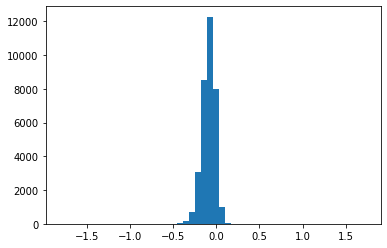

In [80]:
plt.hist(samp,bins=50)
plt.show()

# Using nearest allow it to choose the nearest one. I don't really want to do this but due to memory concerns ok

In [32]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [48]:

import math
m=math.atan(2.02)

xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]
x_input=jnp.stack([xc_meas,xg_meas],axis=1)

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]
x_err=jnp.stack([xc_std,xg_std],axis=1)

def model(isochrone,x_input,x_err,x_obs=None,y_obs=None):
    import math
    d=numpyro.sample("d",mixture,rng_key=rng_key).reshape(1)
    dx=math.cos(m)
    dy=math.sin(m)

    truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
    truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
    truth=jnp.logical_and(truth_1,truth_2)

    transformed_x=isochrone[:,:,column_index('BPRP')]+d*dx
    transformed_y=isochrone[:,:,column_index('Gaia_G_EDR3')]+d*dy

    a1=-1*isochrone[:,:,column_index('slopes')]
    b1=1.0
    c1=isochrone[:,:,column_index('slopes')]*transformed_x-transformed_y


    a2=-1*isochrone[:,:,column_index('p_slopes')]
    b2=1.0
    c2=isochrone[:,:,column_index('p_slopes')]*isochrone[:,:,column_index('bp_rp')]-isochrone[:,:,column_index('G')]


    x=(b1*c2-b2*c1)/(a1*b2-a2*b1)
    y=(a2*c1-a1*c2)/(a1*b2-a2*b1)

    sgn=jnp.sign((y-isochrone[:,:,column_index('G')])/(x-isochrone[:,:,column_index('bp_rp')]))

    do=jnp.sqrt((x-isochrone[:,:,column_index('bp_rp')])**2+(y-isochrone[:,:,column_index('G')])**2)

    idx=jnp.argmin(jnp.argmin(jnp.nan_to_num(do,nan=jnp.inf),-1),-1)


    
    transformed_y=jnp.take_along_axis(y,idx.reshape(-1,1),1)
    transformed_x=jnp.take_along_axis(x,idx.reshape(-1,1),1)
    
    print(transformed_x)
    transformed_x=transformed_x.reshape(transformed_x.shape[0])
    transformed_y=transformed_y.reshape(transformed_y.shape[0])
    #transformed=jnp.stack([transformed_x,transformed_y],axis=1)
    
    # not 100 percent sure on this

    with numpyro.plate('data',len(x_err)):
        numpyro.sample("obs_x",dist.Normal(transformed_x,xc_std**2),rng_key=rng_key,obs=x_obs)
        numpyro.sample("obs_y",dist.Normal(transformed_y,xg_std**2),rng_key=rng_key,obs=y_obs)






In [49]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2,num_chains=1,progress_bar=True)
mcmc.run(rng_key, isochrone, x_input,x_err, x_obs=xc_meas,y_obs=xg_meas)

posterior_samples = mcmc.get_samples()

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
Traced<ConcreteArray([[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([[nan],
             [nan],
             [nan],
             ...,
             [nan],
             [nan],
             [nan]], dtype=float32)
  tangent = Traced<ShapedArray(float32[33924,1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[33924,1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x146da58f0>, in_tracers=(Traced<ConcreteArray([[717]], dtype=int32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[33924,96]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x32a2a0090; to 'JaxprTracer' at 0x32a2a0f40>], out_avals=[ShapedArray(float32[33924,1])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'take_along_axis', 'donated_invars': (False, False), 'inline': False, 'keep_unused': False, 'call_jaxpr': { lambda ; a:i32[1,1] b:f32[33924,96

ValueError: Normal distribution got invalid loc parameter.

In [ ]:
numpyro.set_host_device_count(3)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_54160/2449899603.py:3: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=2, num_warmup=2,num_chains=3,progress_bar=True)


In [ ]:
x_err.shape

(3708096, 2)

In [ ]:
jnp.diag(x_err)

DeviceArray([0.06460058, 0.00375002], dtype=float32)